In [1]:
from platform import python_version
print(python_version())

3.6.13


In [2]:
import tensorflow as tf
print(tf.__version__)

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages

1.14.0


C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Falcone\anaconda3\envs\MaskR

In [3]:
import keras
print(keras.__version__)

2.2.5


Using TensorFlow backend.


In [8]:
# Esse dataset possui imagens e anotações em XML sobre cada imagem. O Python tem algumas funções prontas para 
# extrair informações de um XML: 

from xml.etree import ElementTree
 
# Função para extrair os limites da caixa do arquivo de anotações XML:
def extrair_caixas(endereco_arquivo):
    arquivo = ElementTree.parse(endereco_arquivo) # carregando o arquivo e instanciando a função parse
    raiz = arquivo.getroot() # iniciando da raiz do documento
    # extraindo cada limite da caixa de dentro do marcador bndbox:
    caixas = []
    for caixa in raiz.findall('.//bndbox'):
        xmin = int(caixa.find('xmin').text)
        ymin = int(caixa.find('ymin').text)
        xmax = int(caixa.find('xmax').text)
        ymax = int(caixa.find('ymax').text)
        coordenadas = [xmin, ymin, xmax, ymax]
        caixas.append(coordenadas)
    # extraindo as dimensões da imagem de dentro do marcador size:
    largura = int(raiz.find('.//size/width').text)
    altura = int(raiz.find('.//size/height').text)
    return caixas, largura, altura
 
# testando a função:
caixas, l, a = extrair_caixas('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/annots/00001.xml')
# Mostrando o que foi extraído:
print(caixas, l, a)

[[233, 89, 386, 262], [134, 105, 341, 253]] 450 319


In [9]:
# Já existe uma função built-in load_mask(), mas como as máscaras podem ser escritas de diferentes formas, vamos
# sobreescrever a função built-in com uma função personalizada.

# Existem duas funções buit-in que iremos usar: add_class() e add_image(), que definem as classes e as imagens. 

# Na função add_class(), precisamos informar o nome do dataset, o número da classe (1 para canguru, 0 é reservado 
# para background), e o nome da classe (nesse caso, 1 é o número e 'kangaroo' é o nome).
# Resumindo: add_class('dataset_name', 1, 'kangaroo')

# Na função add_image(), precisamos informar: nome do dataset, nome do arquivo e o diretório que esse arquivo está. 
# Também podemos inserir outras informações nessa função, como o diretório que contém o arquivo com as anotações. 
# Resumindo: add_image('dataset_name', image_id='00001', path='kangaroo/images/00001.jpg', annotation='kangaroo/annots/00001.xml')

# O que queremos fazer é passar as informações de todas as imagens e classes. Vamos então criar uma função que vai
# varrer nossos diretórios e coletar essas informações de cada imagem, colocando cada uma dentro de add_image() e 
# add_class().
# Essa função será chamada de carrega_dataset(), e vamos aproveitar já para dividir o dataset em treino e teste:
def carrega_dataset(self, endereco_dataset, treino_selecionado=True):
    self.add_class("dataset", 1, "kangaroo") # aplica a função add_class()
    # organizando os diretórios onde estão as imagens e as anotações:
    endereco_imagens = endereco_dataset + '/images/' 
    endereco_anotacoes = endereco_dataset + '/annots/'
    # Encontrando todas as imagens e suas anotações para passar para a função add_image():
    for nome_imagem in listdir(endereco_imagens): # a função listdir retorna todos arquivos e diretórios existentes no caminho especificado      
        imagem_id = nome_imagem[:-4] # Pega o id da imagem (ignora o .jpg no final)
        if imagem_id in ['00090']: # Pula uma imagem com problema
            continue # quando o if é satisfeito, não continua, retornando para o próximo loop
        if treino_selecionado and int(imagem_id) >= 150: # Pula todas as imagens depois da 150 se estamos criando o dataset de treino
            continue
        if not treino_selecionado and int(imagem_id) < 150: # Pula todas as imagens antes da 150 se estamos criando o dataset de teste
            continue
        diretorio_completo_imagem = endereco_imagens + nome_imagem # Pega o diretório da imagem jpg
        diretorio_completo_anotacao = endereco_anotacoes + imagem_id + '.xml' # Pega o diretório da anotação XML da imagem
        self.add_image('dataset', image_id=imagem_id, path=diretorio_completo_imagem, annotation=diretorio_completo_anotacao) # Aplica na função add_image()

In [10]:
# Criando uma função que carrega a máscara de uma imagem específica:
def load_mask(self, imagem_id): # recebe o id da imagem como entrada
    informacoes_imagem = self.image_info[imagem_id] # recupera todas as informações passadas para add_image() a partir do image_id. É built-in.
    diretorio_anotacao = informacoes_imagem['annotation'] # salva o diretório da anotação dessa imagem
    caixas, l, a = self.extrair_caixas(diretorio_anotacao) # carrega o arquivo XML com base no diretório da anotação
    mascaras = zeros([a, l, len(caixas)], dtype='uint8') # Cria uma máscara de zeros com dimensão da imagem e profundidade da quantidade de caixas que há na imagem em questão. 
    # Colocando 1's em todo o tamanho de cada caixa dentro figura. Cada caixa será colocada em uma dimensão de profundidade:
    classes_ids = []
    for i in range(len(caixas)): # varrendo uma caixa de cada vez
        caixa = caixas[i] # caixa atual
        x_inicio, x_final = caixa[1], caixa[3] # coleta x_min e x_máx
        y_inicio, y_final = caixa[0], caixa[2] # coleta y_min e y_máx
        mascaras[x_inicio:x_final, y_inicio:y_final, i] = 1 # colocando 1's em todo o retângulo formado
        classes_ids.append(self.class_names.index('kangaroo')) # self.class_names contém o nome e o número das classes passadas para add_class()
    return mascaras, asarray(classes_ids, dtype='int32') # retorna a máscara, e a classe (em um array int32. Se houver duas caixas, ambas das classes 1, essa saída será [1, 1])

In [11]:
# Implementando tudo que fizemos até aqui em um único código:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
 
class DatasetCanguru(Dataset):
    def carrega_dataset(self, endereco_dataset, treino_selecionado=True):
        self.add_class("dataset", 1, "kangaroo")
        endereco_imagens = endereco_dataset + '/images/' 
        endereco_anotacoes = endereco_dataset + '/annots/'
        for nome_imagem in listdir(endereco_imagens): 
            imagem_id = nome_imagem[:-4] 
            if imagem_id in ['00090']:
                continue 
            if treino_selecionado and int(imagem_id) >= 150: 
                continue
            if not treino_selecionado and int(imagem_id) < 150: 
                continue
            diretorio_completo_imagem = endereco_imagens + nome_imagem 
            diretorio_completo_anotacao = endereco_anotacoes + imagem_id + '.xml' 
            self.add_image('dataset', image_id=imagem_id, path=diretorio_completo_imagem, annotation=diretorio_completo_anotacao) 
 
    def extrair_caixas(self, endereco_arquivo):
        arquivo = ElementTree.parse(endereco_arquivo) 
        raiz = arquivo.getroot() 
        caixas = []
        for caixa in raiz.findall('.//bndbox'):
            xmin = int(caixa.find('xmin').text)
            ymin = int(caixa.find('ymin').text)
            xmax = int(caixa.find('xmax').text)
            ymax = int(caixa.find('ymax').text)
            coordenadas = [xmin, ymin, xmax, ymax]
            caixas.append(coordenadas)
        largura = int(raiz.find('.//size/width').text)
        altura = int(raiz.find('.//size/height').text)
        return caixas, largura, altura
 
    def load_mask(self, imagem_id): 
        informacoes_imagem = self.image_info[imagem_id] 
        diretorio_anotacao = informacoes_imagem['annotation'] 
        caixas, l, a = self.extrair_caixas(diretorio_anotacao) 
        mascaras = zeros([a, l, len(caixas)], dtype='uint8') 
        classes_ids = []
        for i in range(len(caixas)): 
            caixa = caixas[i] 
            x_inicio, x_final = caixa[1], caixa[3] 
            y_inicio, y_final = caixa[0], caixa[2] 
            mascaras[x_inicio:x_final, y_inicio:y_final, i] = 1 
            classes_ids.append(self.class_names.index('kangaroo'))
        return mascaras, asarray(classes_ids, dtype='int32') 

In [12]:
# Criando o dataset de treino:
dataset_treino = DatasetCanguru() # instancia a classe criada
dataset_treino.carrega_dataset('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo', treino_selecionado=True) # carrega o dataset
dataset_treino.prepare() # usa a função built-in prepare() para preparar o dataset carregado (passa alguns atributos carregados para variáveis internas)
print('Tamanho Treino: %d' % len(dataset_treino.image_ids))
 
# Criando o dataset de teste:
dataset_teste = DatasetCanguru()
dataset_teste.carrega_dataset('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo', treino_selecionado=False)
dataset_teste.prepare()
print('Tamanho Teste: %d' % len(dataset_teste.image_ids))

Tamanho Treino: 131
Tamanho Teste: 32


(319, 450, 3)
(319, 450, 1)


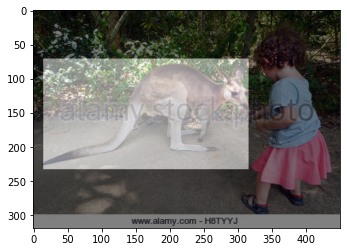

In [13]:
# Verificando se está tudo ok ao carregar uma imagem:

import matplotlib.pyplot as plt
imagem_id = 3 # escolhendo uma imagem específica
imagem = dataset_treino.load_image(imagem_id) # aplica a função built-in load_image()
print(imagem.shape) # mostrando o shape da imagem
mascara, classes_ids = dataset_treino.load_mask(imagem_id) # aplica a função load_mask()
print(mascara.shape) # mostrando o shape da máscara da imagem
plt.imshow(imagem) # mostrando a imagem
plt.imshow(mascara[:, :, 0], cmap='gray', alpha=0.5) # mostrando a máscara da imagem. alpha é a transparência (1 é o default, menos que 1 fica mais transparente). cmap é o mapa de cores escolhido. Nesse caso, cinza.
plt.show()

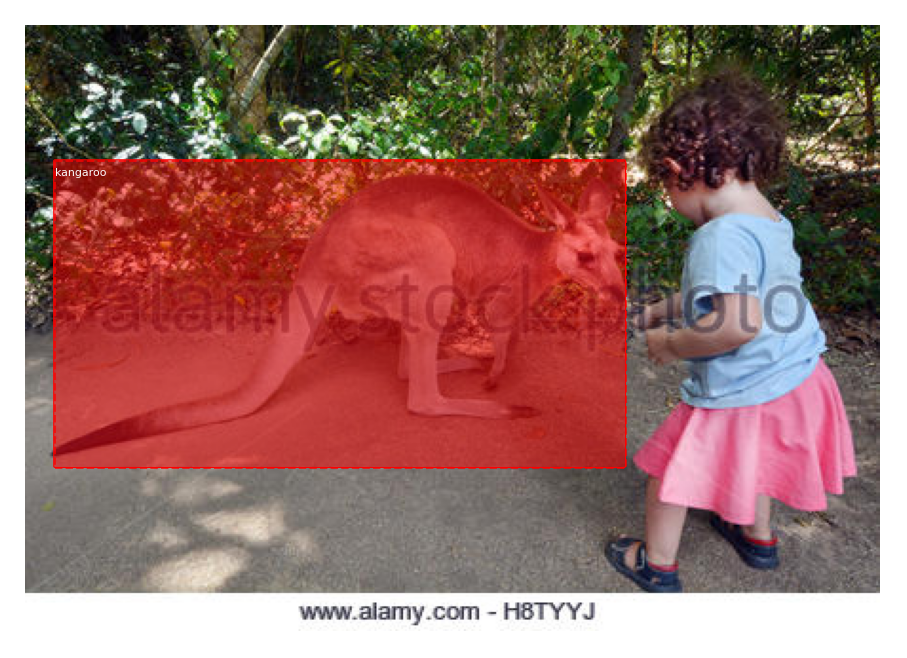

In [14]:
# Mais uma verificação, dessa vez colocando o nome da classe em volta da imagem:

from mrcnn.utils import extract_bboxes
from mrcnn.visualize import display_instances
imagem_id = 3 # escolhendo uma imagem específica
imagem = dataset_treino.load_image(imagem_id) # aplica a função built-in load_image()
mascara, classes_ids = dataset_treino.load_mask(imagem_id) # aplica a função load_mask()
dimensoes_caixas = extract_bboxes(mascara) # aplica a função built-in extract_bboxes()
display_instances(imagem, dimensoes_caixas, mascara, classes_ids, dataset_treino.class_names) # mostra os dados coletados usando a função built-in display_instances()

In [16]:
# Criando uma classe de configurações básicas

from mrcnn.config import Config
from mrcnn.model import MaskRCNN

class ConfiguracoesCangurus(Config): 
    NAME = "configuracoes_cangurus" # atribui um nome para a configuração
    NUM_CLASSES = 2 # define o número de classes (background + kangaroo)
    STEPS_PER_EPOCH = 131 # define o número de passadas por epoch 
    GPU_COUNT = 1 # quantas GPUs serão utilizadas
    IMAGES_PER_GPU = 2 # quantas imagens serão passadas para a GPU de cada vez

config = ConfiguracoesCangurus()

# Criando o modelo:
modelo = MaskRCNN(mode='training', model_dir='C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/treino', config=config) # Em model_dir, informamos onde o modelo treinado será salvo. Em mode, podemos informar se é 'training' ou 'inference'
# Baixando o modelo COCO treinado: https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
modelo.load_weights('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"]) # carregando pesos de um modelo já treinado, excluindo algumas camadas/layers inúteis para nosso caso
modelo.train(dataset_treino, dataset_teste, learning_rate=0.001, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/treino\configuracoes_cangurus20220725T2311\mask_rcnn_configuracoes_cangurus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (Tim

AttributeError: 'Model' object has no attribute 'metrics_tensors'

In [4]:
# RODANDO O CÓDIGO COMPLETO

from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN


class DatasetCanguru(Dataset):
    def carrega_dataset(self, endereco_dataset, treino_selecionado=True):
        self.add_class("dataset", 1, "kangaroo")
        endereco_imagens = endereco_dataset + '/images/' 
        endereco_anotacoes = endereco_dataset + '/annots/'
        for nome_imagem in listdir(endereco_imagens): 
            imagem_id = nome_imagem[:-4] 
            if imagem_id in ['00090']:
                continue 
            if treino_selecionado and int(imagem_id) >= 150: 
                continue
            if not treino_selecionado and int(imagem_id) < 150: 
                continue
            diretorio_completo_imagem = endereco_imagens + nome_imagem 
            diretorio_completo_anotacao = endereco_anotacoes + imagem_id + '.xml' 
            self.add_image('dataset', image_id=imagem_id, path=diretorio_completo_imagem, annotation=diretorio_completo_anotacao) 
 
    def extrair_caixas(self, endereco_arquivo):
        arquivo = ElementTree.parse(endereco_arquivo) 
        raiz = arquivo.getroot() 
        caixas = []
        for caixa in raiz.findall('.//bndbox'):
            xmin = int(caixa.find('xmin').text)
            ymin = int(caixa.find('ymin').text)
            xmax = int(caixa.find('xmax').text)
            ymax = int(caixa.find('ymax').text)
            coordenadas = [xmin, ymin, xmax, ymax]
            caixas.append(coordenadas)
        largura = int(raiz.find('.//size/width').text)
        altura = int(raiz.find('.//size/height').text)
        return caixas, largura, altura
 
    def load_mask(self, imagem_id): 
        informacoes_imagem = self.image_info[imagem_id] 
        diretorio_anotacao = informacoes_imagem['annotation'] 
        caixas, l, a = self.extrair_caixas(diretorio_anotacao) 
        mascaras = zeros([a, l, len(caixas)], dtype='uint8') 
        classes_ids = []
        for i in range(len(caixas)): 
            caixa = caixas[i] 
            x_inicio, x_final = caixa[1], caixa[3] 
            y_inicio, y_final = caixa[0], caixa[2] 
            mascaras[x_inicio:x_final, y_inicio:y_final, i] = 1 
            classes_ids.append(self.class_names.index('kangaroo'))
        return mascaras, asarray(classes_ids, dtype='int32') 

# Quando formos chamar o modelo, tereremos que passar as configurações na forma de uma classe:
class ConfiguracoesCangurus(Config): 
    NAME = "configuracoes_cangurus" 
    NUM_CLASSES = 2 
    STEPS_PER_EPOCH = 131 
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 
    
# Criando o dataset de treino:
dataset_treino = DatasetCanguru() 
dataset_treino.carrega_dataset('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo', treino_selecionado=True) 
dataset_treino.prepare() 
print('Tamanho Treino: %d' % len(dataset_treino.image_ids))
 
# Criando o dataset de teste:
dataset_teste = DatasetCanguru()
dataset_teste.carrega_dataset('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo', treino_selecionado=False)
dataset_teste.prepare()
print('Tamanho Teste: %d' % len(dataset_teste.image_ids))

# Preparando as configurações:

config = ConfiguracoesCangurus()

# Criando o modelo:
# Os pesos e bias serao salvos na pasta treino, no caminho abaixo
modelo = MaskRCNN(mode='training', model_dir='C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/treino', config=config) 
modelo.load_weights('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"]) 
modelo.train(dataset_treino, dataset_teste, learning_rate=0.001, epochs=5, layers='heads')

# O algoritmo treina com base nas caixas e máscaras. Provando:
# Quando se executa a função train() da classe MaskRCNN, ele pega para treinar o train_dataset, que é a classe que nós
# criamos: DatasetCanguru(). Essa classe contém a função load_mask(). Durante o treinamento, essa função será 
# chamada, pois ela está dentro de load_image_gt(), que por sua vez está dentro de data_generator(), que por sua
# vez está dentro de train(). Basta checar no código oficial: https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/model.py

Tamanho Treino: 131
Tamanho Teste: 32






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead

Starting at epoch 0. LR=0.001

Checkpoint Path: C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/treino\configuracoes_cangurus20220728T1102\mask_rcnn_configuracoes_cangurus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2    

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "




Epoch 1/5


C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:32:26 - loss: 4.4537 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 1.9281 - mrcnn_bbox_loss: 1.4745 - mrcnn_mask_loss: 1.0026

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:28:44 - loss: 4.0342 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 1.5887 - mrcnn_bbox_loss: 1.3375 - mrcnn_mask_loss: 1.0236

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:26:28 - loss: 3.6563 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1054 - mrcnn_class_loss: 1.1675 - mrcnn_bbox_loss: 1.3297 - mrcnn_mask_loss: 1.0492

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:25:02 - loss: 3.2489 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.8922 - mrcnn_bbox_loss: 1.2176 - mrcnn_mask_loss: 1.0440

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:23:40 - loss: 3.0229 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.7492 - mrcnn_bbox_loss: 1.1843 - mrcnn_mask_loss: 1.0063

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:22:55 - loss: 2.8445 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.6614 - mrcnn_bbox_loss: 1.1321 - mrcnn_mask_loss: 0.9678

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:21:53 - loss: 2.7286 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.6034 - mrcnn_bbox_loss: 1.1062 - mrcnn_mask_loss: 0.9357

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:21:05 - loss: 2.5746 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.5331 - mrcnn_bbox_loss: 1.0515 - mrcnn_mask_loss: 0.9135

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:20:10 - loss: 2.4553 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.4841 - mrcnn_bbox_loss: 1.0087 - mrcnn_mask_loss: 0.8882

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:19:13 - loss: 2.3933 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.4377 - mrcnn_bbox_loss: 1.0057 - mrcnn_mask_loss: 0.8658

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:18:33 - loss: 2.4065 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.4026 - mrcnn_bbox_loss: 1.0433 - mrcnn_mask_loss: 0.8418

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:17:53 - loss: 2.3298 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1094 - mrcnn_class_loss: 0.3712 - mrcnn_bbox_loss: 1.0241 - mrcnn_mask_loss: 0.8213

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:17:48 - loss: 2.2602 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1168 - mrcnn_class_loss: 0.3480 - mrcnn_bbox_loss: 0.9919 - mrcnn_mask_loss: 0.8001

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:17:33 - loss: 2.2073 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1182 - mrcnn_class_loss: 0.3284 - mrcnn_bbox_loss: 0.9744 - mrcnn_mask_loss: 0.7831

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:16:58 - loss: 2.1432 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1179 - mrcnn_class_loss: 0.3093 - mrcnn_bbox_loss: 0.9450 - mrcnn_mask_loss: 0.7678

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:16:29 - loss: 2.0975 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 0.9236 - mrcnn_mask_loss: 0.7543

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:16:05 - loss: 2.0434 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.2830 - mrcnn_bbox_loss: 0.9022 - mrcnn_mask_loss: 0.7389

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:15:33 - loss: 1.9920 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1148 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.8815 - mrcnn_mask_loss: 0.7252

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:15:00 - loss: 1.9628 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1176 - mrcnn_class_loss: 0.2552 - mrcnn_bbox_loss: 0.8712 - mrcnn_mask_loss: 0.7152

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:14:31 - loss: 1.9128 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.8482 - mrcnn_mask_loss: 0.7019

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:14:00 - loss: 1.8657 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1125 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.8299 - mrcnn_mask_loss: 0.6876

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:13:24 - loss: 1.8253 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1095 - mrcnn_class_loss: 0.2224 - mrcnn_bbox_loss: 0.8113 - mrcnn_mask_loss: 0.6788

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 1:12:51 - loss: 1.7803 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.2128 - mrcnn_bbox_loss: 0.7870 - mrcnn_mask_loss: 0.6675

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 1:12:16 - loss: 1.7395 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.1071 - mrcnn_class_loss: 0.2044 - mrcnn_bbox_loss: 0.7668 - mrcnn_mask_loss: 0.6583

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 1:11:42 - loss: 1.7078 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.1963 - mrcnn_bbox_loss: 0.7512 - mrcnn_mask_loss: 0.6489

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 1:11:07 - loss: 1.6772 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1048 - mrcnn_class_loss: 0.1905 - mrcnn_bbox_loss: 0.7391 - mrcnn_mask_loss: 0.6396

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 1:10:31 - loss: 1.6568 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.1840 - mrcnn_bbox_loss: 0.7261 - mrcnn_mask_loss: 0.6327

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 1:09:56 - loss: 1.6456 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.1803 - mrcnn_bbox_loss: 0.7153 - mrcnn_mask_loss: 0.6242

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 1:09:23 - loss: 1.6201 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.1746 - mrcnn_bbox_loss: 0.7061 - mrcnn_mask_loss: 0.6146

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 1:08:47 - loss: 1.6252 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1363 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.7032 - mrcnn_mask_loss: 0.6128

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 1:08:12 - loss: 1.5963 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.1635 - mrcnn_bbox_loss: 0.6902 - mrcnn_mask_loss: 0.6040

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:07:36 - loss: 1.5820 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.1596 - mrcnn_bbox_loss: 0.6825 - mrcnn_mask_loss: 0.5967

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:07:02 - loss: 1.5787 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1466 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.6827 - mrcnn_mask_loss: 0.5901

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:06:26 - loss: 1.5613 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1465 - mrcnn_class_loss: 0.1521 - mrcnn_bbox_loss: 0.6753 - mrcnn_mask_loss: 0.5835

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:05:48 - loss: 1.5442 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1443 - mrcnn_class_loss: 0.1479 - mrcnn_bbox_loss: 0.6721 - mrcnn_mask_loss: 0.5761

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:05:10 - loss: 1.5352 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1500 - mrcnn_class_loss: 0.1442 - mrcnn_bbox_loss: 0.6656 - mrcnn_mask_loss: 0.5717

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:04:32 - loss: 1.5170 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1477 - mrcnn_class_loss: 0.1405 - mrcnn_bbox_loss: 0.6595 - mrcnn_mask_loss: 0.5657

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:03:54 - loss: 1.5013 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1464 - mrcnn_class_loss: 0.1371 - mrcnn_bbox_loss: 0.6503 - mrcnn_mask_loss: 0.5639

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:03:16 - loss: 1.4859 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1445 - mrcnn_class_loss: 0.1339 - mrcnn_bbox_loss: 0.6455 - mrcnn_mask_loss: 0.5584

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 1:02:39 - loss: 1.5013 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1650 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.6498 - mrcnn_mask_loss: 0.5520

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 1:02:01 - loss: 1.4883 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1622 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.6495 - mrcnn_mask_loss: 0.5454

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 1:01:21 - loss: 1.4748 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1601 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.6461 - mrcnn_mask_loss: 0.5395

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 1:00:43 - loss: 1.4627 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1593 - mrcnn_class_loss: 0.1227 - mrcnn_bbox_loss: 0.6425 - mrcnn_mask_loss: 0.5343

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 1:00:04 - loss: 1.4489 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1574 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.6365 - mrcnn_mask_loss: 0.5295

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 59:25 - loss: 1.4296 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1569 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.6256 - mrcnn_mask_loss: 0.5239  

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 58:45 - loss: 1.4249 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1603 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.6237 - mrcnn_mask_loss: 0.5199

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 58:07 - loss: 1.4140 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1630 - mrcnn_class_loss: 0.1150 - mrcnn_bbox_loss: 0.6168 - mrcnn_mask_loss: 0.5156

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 57:24 - loss: 1.3983 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1616 - mrcnn_class_loss: 0.1131 - mrcnn_bbox_loss: 0.6095 - mrcnn_mask_loss: 0.5105

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 56:41 - loss: 1.3869 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1609 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.6038 - mrcnn_mask_loss: 0.5074

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 55:55 - loss: 1.3693 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1590 - mrcnn_class_loss: 0.1090 - mrcnn_bbox_loss: 0.5946 - mrcnn_mask_loss: 0.5032

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 55:11 - loss: 1.3620 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1598 - mrcnn_class_loss: 0.1074 - mrcnn_bbox_loss: 0.5911 - mrcnn_mask_loss: 0.5002

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 54:29 - loss: 1.3495 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1585 - mrcnn_class_loss: 0.1055 - mrcnn_bbox_loss: 0.5864 - mrcnn_mask_loss: 0.4956

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 53:48 - loss: 1.3368 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1578 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.5791 - mrcnn_mask_loss: 0.4930

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 53:09 - loss: 1.3273 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1570 - mrcnn_class_loss: 0.1018 - mrcnn_bbox_loss: 0.5741 - mrcnn_mask_loss: 0.4912

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 52:27 - loss: 1.3176 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1565 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.5701 - mrcnn_mask_loss: 0.4876

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 51:45 - loss: 1.3072 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1570 - mrcnn_class_loss: 0.0988 - mrcnn_bbox_loss: 0.5648 - mrcnn_mask_loss: 0.4833

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 51:03 - loss: 1.2928 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1559 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.5575 - mrcnn_mask_loss: 0.4790

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 50:21 - loss: 1.2898 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1570 - mrcnn_class_loss: 0.0962 - mrcnn_bbox_loss: 0.5564 - mrcnn_mask_loss: 0.4770

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 49:42 - loss: 1.2809 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1569 - mrcnn_class_loss: 0.0946 - mrcnn_bbox_loss: 0.5525 - mrcnn_mask_loss: 0.4738

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 49:02 - loss: 1.2735 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1557 - mrcnn_class_loss: 0.0933 - mrcnn_bbox_loss: 0.5486 - mrcnn_mask_loss: 0.4727

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 48:24 - loss: 1.2992 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1849 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.5481 - mrcnn_mask_loss: 0.4700

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 47:44 - loss: 1.2911 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1839 - mrcnn_class_loss: 0.0912 - mrcnn_bbox_loss: 0.5447 - mrcnn_mask_loss: 0.4674

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 47:04 - loss: 1.2797 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1822 - mrcnn_class_loss: 0.0904 - mrcnn_bbox_loss: 0.5390 - mrcnn_mask_loss: 0.4640

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 46:25 - loss: 1.2695 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1813 - mrcnn_class_loss: 0.0891 - mrcnn_bbox_loss: 0.5339 - mrcnn_mask_loss: 0.4612

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 45:45 - loss: 1.2591 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1808 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.5281 - mrcnn_mask_loss: 0.4584

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 45:05 - loss: 1.2552 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1808 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.5270 - mrcnn_mask_loss: 0.4568

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 44:24 - loss: 1.2471 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1793 - mrcnn_class_loss: 0.0865 - mrcnn_bbox_loss: 0.5232 - mrcnn_mask_loss: 0.4542

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 43:44 - loss: 1.2424 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1787 - mrcnn_class_loss: 0.0870 - mrcnn_bbox_loss: 0.5206 - mrcnn_mask_loss: 0.4522

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 43:04 - loss: 1.2396 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1794 - mrcnn_class_loss: 0.0860 - mrcnn_bbox_loss: 0.5187 - mrcnn_mask_loss: 0.4516

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 42:24 - loss: 1.2304 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1777 - mrcnn_class_loss: 0.0850 - mrcnn_bbox_loss: 0.5144 - mrcnn_mask_loss: 0.4495

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 41:43 - loss: 1.2194 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1762 - mrcnn_class_loss: 0.0840 - mrcnn_bbox_loss: 0.5089 - mrcnn_mask_loss: 0.4465

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 41:03 - loss: 1.2084 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1743 - mrcnn_class_loss: 0.0829 - mrcnn_bbox_loss: 0.5039 - mrcnn_mask_loss: 0.4435

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 40:23 - loss: 1.1973 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.0819 - mrcnn_bbox_loss: 0.4988 - mrcnn_mask_loss: 0.4406

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 39:42 - loss: 1.1895 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1708 - mrcnn_class_loss: 0.0810 - mrcnn_bbox_loss: 0.4952 - mrcnn_mask_loss: 0.4388

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 39:01 - loss: 1.1853 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1704 - mrcnn_class_loss: 0.0811 - mrcnn_bbox_loss: 0.4927 - mrcnn_mask_loss: 0.4374

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 38:20 - loss: 1.1789 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1696 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.4896 - mrcnn_mask_loss: 0.4358

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 37:40 - loss: 1.1688 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1678 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.4849 - mrcnn_mask_loss: 0.4330

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 36:59 - loss: 1.1619 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1667 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.4816 - mrcnn_mask_loss: 0.4314

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 36:18 - loss: 1.1544 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.4779 - mrcnn_mask_loss: 0.4294

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 35:37 - loss: 1.1510 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1691 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.4734 - mrcnn_mask_loss: 0.4278

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 34:56 - loss: 1.1438 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1679 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.4704 - mrcnn_mask_loss: 0.4255

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 34:15 - loss: 1.1364 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1667 - mrcnn_class_loss: 0.0755 - mrcnn_bbox_loss: 0.4670 - mrcnn_mask_loss: 0.4235

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 33:33 - loss: 1.1343 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1660 - mrcnn_class_loss: 0.0747 - mrcnn_bbox_loss: 0.4668 - mrcnn_mask_loss: 0.4231

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 32:52 - loss: 1.1268 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1647 - mrcnn_class_loss: 0.0740 - mrcnn_bbox_loss: 0.4636 - mrcnn_mask_loss: 0.4208

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 32:11 - loss: 1.1208 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1637 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.4603 - mrcnn_mask_loss: 0.4194

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 31:30 - loss: 1.1149 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1641 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.4566 - mrcnn_mask_loss: 0.4175

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 30:48 - loss: 1.1065 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1627 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.4529 - mrcnn_mask_loss: 0.4151

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 30:07 - loss: 1.0994 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1625 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.4488 - mrcnn_mask_loss: 0.4131

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 29:26 - loss: 1.0941 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1623 - mrcnn_class_loss: 0.0707 - mrcnn_bbox_loss: 0.4459 - mrcnn_mask_loss: 0.4116

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 28:44 - loss: 1.0898 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1614 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.4438 - mrcnn_mask_loss: 0.4106

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 28:02 - loss: 1.0853 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1611 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.4407 - mrcnn_mask_loss: 0.4099

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 27:21 - loss: 1.0817 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1611 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.4388 - mrcnn_mask_loss: 0.4088

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 26:39 - loss: 1.0758 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1602 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.4366 - mrcnn_mask_loss: 0.4066

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 25:58 - loss: 1.0749 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1618 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.4359 - mrcnn_mask_loss: 0.4056

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 25:15 - loss: 1.0687 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1607 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.4332 - mrcnn_mask_loss: 0.4038

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 24:34 - loss: 1.0647 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1610 - mrcnn_class_loss: 0.0669 - mrcnn_bbox_loss: 0.4306 - mrcnn_mask_loss: 0.4025

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 23:51 - loss: 1.0603 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1604 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.4279 - mrcnn_mask_loss: 0.4018

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 23:09 - loss: 1.0544 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1598 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.4244 - mrcnn_mask_loss: 0.4006

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 22:27 - loss: 1.0512 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1584 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.3997

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 21:45 - loss: 1.0454 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1577 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.4210 - mrcnn_mask_loss: 0.3983

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 21:02 - loss: 1.0451 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1577 - mrcnn_class_loss: 0.0644 - mrcnn_bbox_loss: 0.4213 - mrcnn_mask_loss: 0.3979

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 20:20 - loss: 1.0405 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1569 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.4194 - mrcnn_mask_loss: 0.3967

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 19:38 - loss: 1.0349 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1558 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.4171 - mrcnn_mask_loss: 0.3950

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 18:56 - loss: 1.0321 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1568 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.3937

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 18:13 - loss: 1.0295 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1560 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.3927

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 17:31 - loss: 1.0265 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1563 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.4129 - mrcnn_mask_loss: 0.3913

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 16:49 - loss: 1.0211 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1553 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.3896

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 16:07 - loss: 1.0157 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1544 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.4081 - mrcnn_mask_loss: 0.3884

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 15:24 - loss: 1.0119 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1537 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.4068 - mrcnn_mask_loss: 0.3870

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 14:42 - loss: 1.0159 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1574 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.4072 - mrcnn_mask_loss: 0.3869

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 14:00 - loss: 1.0113 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1565 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.4059 - mrcnn_mask_loss: 0.3851

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 13:18 - loss: 1.0064 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1556 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.4043 - mrcnn_mask_loss: 0.3832

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 12:36 - loss: 1.0036 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1556 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.4025 - mrcnn_mask_loss: 0.3826

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 11:53 - loss: 1.0015 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1552 - mrcnn_class_loss: 0.0590 - mrcnn_bbox_loss: 0.4011 - mrcnn_mask_loss: 0.3823

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 11:10 - loss: 0.9967 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1545 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.3990 - mrcnn_mask_loss: 0.3808

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 10:28 - loss: 0.9933 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1545 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.3976 - mrcnn_mask_loss: 0.3792

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 9:46 - loss: 0.9895 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1536 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.3961 - mrcnn_mask_loss: 0.3783 

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 9:03 - loss: 0.9865 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1534 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.3942 - mrcnn_mask_loss: 0.3779

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 8:21 - loss: 0.9899 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1546 - mrcnn_class_loss: 0.0595 - mrcnn_bbox_loss: 0.3939 - mrcnn_mask_loss: 0.3780

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 7:39 - loss: 0.9906 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1577 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.3923 - mrcnn_mask_loss: 0.3775

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 6:57 - loss: 0.9859 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1571 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.3900 - mrcnn_mask_loss: 0.3762

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 6:15 - loss: 0.9806 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1560 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.3747

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 5:33 - loss: 0.9866 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1639 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.3740

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 4:51 - loss: 0.9861 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1660 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.3851 - mrcnn_mask_loss: 0.3735

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 4:09 - loss: 0.9813 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.3826 - mrcnn_mask_loss: 0.3722

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 3:28 - loss: 0.9782 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1648 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.3811 - mrcnn_mask_loss: 0.3716

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:46 - loss: 0.9749 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1644 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.3802 - mrcnn_mask_loss: 0.3700

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 2:04 - loss: 0.9722 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1642 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.3785 - mrcnn_mask_loss: 0.3694

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:23 - loss: 0.9681 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1634 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.3768 - mrcnn_mask_loss: 0.3683

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 41s - loss: 0.9663 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.3747 - mrcnn_mask_loss: 0.3668 

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

131/131 [==============================] - 5927s 45s/step - loss: 0.9635 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1649 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.3739 - mrcnn_mask_loss: 0.3658 - val_loss: 0.8125 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.3184 - val_mrcnn_class_loss: 0.0162 - val_mrcnn_bbox_loss: 0.2113 - val_mrcnn_mask_loss: 0.2584
Epoch 2/5


C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:23:26 - loss: 0.9017 - rpn_class_loss: 9.8305e-04 - rpn_bbox_loss: 0.1553 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.3263 - mrcnn_mask_loss: 0.3763

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:22:48 - loss: 0.7247 - rpn_class_loss: 6.0213e-04 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.2490 - mrcnn_mask_loss: 0.3285

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:22:00 - loss: 0.6399 - rpn_class_loss: 5.8710e-04 - rpn_bbox_loss: 0.1058 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.2042 - mrcnn_mask_loss: 0.3020

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:21:15 - loss: 0.5728 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.2823    

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:20:28 - loss: 0.5694 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.2823

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:19:49 - loss: 0.5621 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.1635 - mrcnn_mask_loss: 0.2739

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:19:07 - loss: 0.5933 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1040 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.1713 - mrcnn_mask_loss: 0.2737

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:18:23 - loss: 0.5691 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.0359 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.2628

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:17:53 - loss: 0.5777 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1141 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.2576

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:17:14 - loss: 0.5619 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.2536

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:16:39 - loss: 0.5466 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.2496

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:15:59 - loss: 0.5499 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1000 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1593 - mrcnn_mask_loss: 0.2601

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:15:19 - loss: 0.5568 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.1623 - mrcnn_mask_loss: 0.2608

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:14:39 - loss: 0.5512 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1038 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.2583

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:14:00 - loss: 0.5386 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1537 - mrcnn_mask_loss: 0.2529

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:13:22 - loss: 0.5289 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.2485

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:12:43 - loss: 0.5143 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2436

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:12:01 - loss: 0.5063 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1406 - mrcnn_mask_loss: 0.2407

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:11:26 - loss: 0.5045 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1408 - mrcnn_mask_loss: 0.2428

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:10:45 - loss: 0.5029 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1407 - mrcnn_mask_loss: 0.2431

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:10:07 - loss: 0.5060 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1413 - mrcnn_mask_loss: 0.2430

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:09:27 - loss: 0.5002 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1400 - mrcnn_mask_loss: 0.2417

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 1:08:47 - loss: 0.4932 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.2401

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 1:08:07 - loss: 0.4893 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.1370 - mrcnn_mask_loss: 0.2377

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 1:07:26 - loss: 0.4914 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.1412 - mrcnn_mask_loss: 0.2379

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 1:06:49 - loss: 0.4903 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.1438 - mrcnn_mask_loss: 0.2368

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 1:06:11 - loss: 0.4878 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2366

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 1:05:33 - loss: 0.4906 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1437 - mrcnn_mask_loss: 0.2382

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 1:04:54 - loss: 0.4894 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1421 - mrcnn_mask_loss: 0.2387

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 1:04:16 - loss: 0.4918 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.1422 - mrcnn_mask_loss: 0.2407

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 1:03:36 - loss: 0.4925 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2401

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:03:05 - loss: 0.4910 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2393

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:02:29 - loss: 0.4911 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1430 - mrcnn_mask_loss: 0.2397

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:01:58 - loss: 0.4980 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2433

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:01:19 - loss: 0.5047 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.2454

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:00:41 - loss: 0.5096 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.2468

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:00:02 - loss: 0.5111 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.1532 - mrcnn_mask_loss: 0.2476

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 59:24 - loss: 0.5239 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1595 - mrcnn_mask_loss: 0.2499  

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 58:46 - loss: 0.5256 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1601 - mrcnn_mask_loss: 0.2524

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 58:08 - loss: 0.5277 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0886 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.2533

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 57:31 - loss: 0.5333 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1616 - mrcnn_mask_loss: 0.2547

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 56:53 - loss: 0.5320 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.1601 - mrcnn_mask_loss: 0.2521

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 56:17 - loss: 0.5326 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1603 - mrcnn_mask_loss: 0.2518

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 55:41 - loss: 0.5309 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.1595 - mrcnn_mask_loss: 0.2506

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 55:02 - loss: 0.5303 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.2497

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 54:25 - loss: 0.5289 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0944 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1584 - mrcnn_mask_loss: 0.2496

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 53:46 - loss: 0.5309 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1587 - mrcnn_mask_loss: 0.2508

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 53:08 - loss: 0.5288 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.2510

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 52:30 - loss: 0.5356 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.2522

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 51:52 - loss: 0.5299 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1587 - mrcnn_mask_loss: 0.2502

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 51:13 - loss: 0.5374 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.2526

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 50:35 - loss: 0.5422 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.2535

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 49:56 - loss: 0.5379 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1617 - mrcnn_mask_loss: 0.2520

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 49:18 - loss: 0.5391 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1622 - mrcnn_mask_loss: 0.2519

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 48:39 - loss: 0.5402 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.1619 - mrcnn_mask_loss: 0.2532

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 48:02 - loss: 0.5430 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.2534

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 47:23 - loss: 0.5449 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0982 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.2550

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 46:45 - loss: 0.5522 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1008 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.2560

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 46:07 - loss: 0.5498 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.2554

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 45:29 - loss: 0.5494 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1012 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.2546

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 44:50 - loss: 0.5495 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1028 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.2542

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 44:11 - loss: 0.5491 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1035 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.2530

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 43:32 - loss: 0.5453 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.2519

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 42:54 - loss: 0.5460 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1654 - mrcnn_mask_loss: 0.2523

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 42:16 - loss: 0.5423 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1642 - mrcnn_mask_loss: 0.2510

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 41:37 - loss: 0.5430 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1033 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.1637 - mrcnn_mask_loss: 0.2509

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 40:59 - loss: 0.5396 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.1624 - mrcnn_mask_loss: 0.2498

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 40:20 - loss: 0.5391 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1022 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1625 - mrcnn_mask_loss: 0.2496

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 39:41 - loss: 0.5366 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1611 - mrcnn_mask_loss: 0.2488

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 39:02 - loss: 0.5367 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1023 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.2487

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 38:24 - loss: 0.5425 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1026 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.2514

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 37:45 - loss: 0.5410 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1025 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.1623 - mrcnn_mask_loss: 0.2509

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 37:07 - loss: 0.5413 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1030 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1617 - mrcnn_mask_loss: 0.2511

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 36:28 - loss: 0.5418 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1038 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.1615 - mrcnn_mask_loss: 0.2512

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 35:50 - loss: 0.5402 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1039 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1607 - mrcnn_mask_loss: 0.2503

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 35:11 - loss: 0.5362 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1029 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.1592 - mrcnn_mask_loss: 0.2489

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 34:32 - loss: 0.5334 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1021 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.2481

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 33:54 - loss: 0.5326 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1017 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.2487

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 33:15 - loss: 0.5305 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.2479

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 32:36 - loss: 0.5310 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1007 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.1566 - mrcnn_mask_loss: 0.2486

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 31:58 - loss: 0.5294 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2484

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 31:19 - loss: 0.5280 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.2478

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 30:41 - loss: 0.5268 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2473

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 30:02 - loss: 0.5258 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1544 - mrcnn_mask_loss: 0.2471

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 29:24 - loss: 0.5235 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0992 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.2466

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 28:45 - loss: 0.5224 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0993 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.2458

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 28:07 - loss: 0.5207 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2455

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 27:28 - loss: 0.5197 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0984 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2449

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 26:50 - loss: 0.5201 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0980 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2451

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 26:12 - loss: 0.5207 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.2461

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 25:33 - loss: 0.5205 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0974 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2460

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 24:55 - loss: 0.5234 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.2466

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 24:17 - loss: 0.5238 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0976 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.1532 - mrcnn_mask_loss: 0.2467

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 23:39 - loss: 0.5223 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1528 - mrcnn_mask_loss: 0.2463

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 23:01 - loss: 0.5231 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0984 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.2460

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 22:22 - loss: 0.5216 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2453

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 21:44 - loss: 0.5208 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0979 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.1517 - mrcnn_mask_loss: 0.2453

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 21:05 - loss: 0.5181 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2445

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 20:27 - loss: 0.5168 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2439

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 19:49 - loss: 0.5143 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.2430

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 19:10 - loss: 0.5152 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.1492 - mrcnn_mask_loss: 0.2431

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 18:32 - loss: 0.5158 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0972 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.2438

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 17:53 - loss: 0.5153 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.2434

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 17:15 - loss: 0.5154 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.2433

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 16:37 - loss: 0.5160 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.1503 - mrcnn_mask_loss: 0.2436

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 15:58 - loss: 0.5149 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.2431

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 15:20 - loss: 0.5146 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.2431

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 14:42 - loss: 0.5130 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.1495 - mrcnn_mask_loss: 0.2424

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 14:04 - loss: 0.5142 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.2433

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 13:25 - loss: 0.5125 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0953 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.2428

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 12:47 - loss: 0.5114 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.2423

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 12:08 - loss: 0.5127 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_loss: 0.2421

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 11:30 - loss: 0.5135 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0959 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_loss: 0.2419

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 10:52 - loss: 0.5176 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0977 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.2428

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 10:13 - loss: 0.5169 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2427

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 9:35 - loss: 0.5197 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0988 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.2434 

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 8:57 - loss: 0.5191 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1518 - mrcnn_mask_loss: 0.2435

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 8:18 - loss: 0.5173 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0983 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1510 - mrcnn_mask_loss: 0.2430

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 7:40 - loss: 0.5157 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.2421

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 7:02 - loss: 0.5148 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0985 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.2417

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 6:23 - loss: 0.5141 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.2413

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 5:45 - loss: 0.5128 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0986 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.2408

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 5:07 - loss: 0.5133 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.2413

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 4:28 - loss: 0.5147 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0987 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.2417

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:50 - loss: 0.5135 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0989 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.2410

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 3:12 - loss: 0.5148 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0992 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1492 - mrcnn_mask_loss: 0.2423

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:33 - loss: 0.5157 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1495 - mrcnn_mask_loss: 0.2431

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:55 - loss: 0.5144 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0988 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1489 - mrcnn_mask_loss: 0.2427

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:16 - loss: 0.5133 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0985 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.1485 - mrcnn_mask_loss: 0.2424

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 38s - loss: 0.5184 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1004 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.2443 

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

131/131 [==============================] - 5510s 42s/step - loss: 0.5181 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1008 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.2442 - val_loss: 0.7539 - val_rpn_class_loss: 0.0082 - val_rpn_bbox_loss: 0.2916 - val_mrcnn_class_loss: 0.0166 - val_mrcnn_bbox_loss: 0.1943 - val_mrcnn_mask_loss: 0.2431
Epoch 3/5


C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:20:13 - loss: 0.3895 - rpn_class_loss: 4.9595e-04 - rpn_bbox_loss: 0.0758 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.2051

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:19:57 - loss: 0.5090 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.1520 - mrcnn_mask_loss: 0.2828    

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:19:47 - loss: 0.4514 - rpn_class_loss: 9.1075e-04 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2556

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:19:12 - loss: 0.4676 - rpn_class_loss: 9.8704e-04 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2538

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:18:45 - loss: 0.4550 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.1241 - mrcnn_mask_loss: 0.2411    

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:18:10 - loss: 0.4360 - rpn_class_loss: 8.8777e-04 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.2341

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:17:37 - loss: 0.4308 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.2348    

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:17:11 - loss: 0.4273 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.2323

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:16:40 - loss: 0.4631 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.2346

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:16:05 - loss: 0.4577 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.2343

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:15:25 - loss: 0.4534 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2335

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:14:51 - loss: 0.4661 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.1170 - mrcnn_mask_loss: 0.2399

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:14:12 - loss: 0.4772 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.2438

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:13:35 - loss: 0.4831 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.2475

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:13:00 - loss: 0.4841 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1235 - mrcnn_mask_loss: 0.2474

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:12:26 - loss: 0.4970 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2491

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:11:51 - loss: 0.4954 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2520

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:11:10 - loss: 0.4866 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.2465

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:10:32 - loss: 0.4785 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.2423

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:09:55 - loss: 0.4743 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.1182 - mrcnn_mask_loss: 0.2412

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:09:20 - loss: 0.4779 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.2402

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:08:43 - loss: 0.4720 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.2381

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 1:08:03 - loss: 0.4633 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.2335

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 1:07:25 - loss: 0.4686 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0909 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.2344

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 1:06:46 - loss: 0.4717 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1203 - mrcnn_mask_loss: 0.2352

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 1:06:08 - loss: 0.4722 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.2366

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 1:05:31 - loss: 0.4725 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.2376

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 1:04:54 - loss: 0.4626 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.2338

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 1:04:18 - loss: 0.4583 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.2329

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 1:03:38 - loss: 0.4519 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2311

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 1:03:02 - loss: 0.4526 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.2326

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:02:24 - loss: 0.4492 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.2323

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:01:46 - loss: 0.4489 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.2336

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:01:08 - loss: 0.4473 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.2327

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:00:31 - loss: 0.4475 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.2334

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 59:54 - loss: 0.4433 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.2324  

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 59:16 - loss: 0.4418 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1106 - mrcnn_mask_loss: 0.2315

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 58:37 - loss: 0.4620 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.2365

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 57:59 - loss: 0.4603 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.2362

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 57:21 - loss: 0.4683 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.2380

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 56:46 - loss: 0.4668 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.2377

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 56:08 - loss: 0.4640 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.2369

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 55:30 - loss: 0.4640 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.2363

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 54:53 - loss: 0.4610 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.2349

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 54:15 - loss: 0.4585 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.1179 - mrcnn_mask_loss: 0.2331

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 53:37 - loss: 0.4570 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.2325

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 52:59 - loss: 0.4539 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.2312

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 52:22 - loss: 0.4540 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.2317

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 51:45 - loss: 0.4554 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.1176 - mrcnn_mask_loss: 0.2315

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 51:07 - loss: 0.4529 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.2298

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 50:30 - loss: 0.4508 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.2282

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 49:51 - loss: 0.4496 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1166 - mrcnn_mask_loss: 0.2276

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 49:13 - loss: 0.4524 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.1171 - mrcnn_mask_loss: 0.2289

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 48:36 - loss: 0.4512 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1174 - mrcnn_mask_loss: 0.2279

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 47:59 - loss: 0.4628 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.2308

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 47:21 - loss: 0.4628 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.2312

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 46:44 - loss: 0.4674 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.1219 - mrcnn_mask_loss: 0.2320

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 46:10 - loss: 0.4648 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0941 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.2311

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 45:32 - loss: 0.4616 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0937 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.2297

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 44:54 - loss: 0.4598 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1197 - mrcnn_mask_loss: 0.2289

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 44:16 - loss: 0.4562 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.2274

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 43:38 - loss: 0.4605 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.2286

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 43:00 - loss: 0.4588 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.2282

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 42:22 - loss: 0.4586 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1184 - mrcnn_mask_loss: 0.2286

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 41:43 - loss: 0.4570 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.2279

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 41:05 - loss: 0.4531 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.2262

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 40:27 - loss: 0.4535 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.2267

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 39:49 - loss: 0.4505 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0914 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.2258

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 39:10 - loss: 0.4488 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.1152 - mrcnn_mask_loss: 0.2250

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 38:33 - loss: 0.4462 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0909 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.2240

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 37:55 - loss: 0.4450 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.2241

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 37:16 - loss: 0.4437 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.2233

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 36:38 - loss: 0.4430 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.2235

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 36:00 - loss: 0.4412 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2234

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 35:22 - loss: 0.4424 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2236

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 34:44 - loss: 0.4392 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2221

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 34:06 - loss: 0.4388 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.2220

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 33:28 - loss: 0.4380 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.2216

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 32:50 - loss: 0.4361 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.2210

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 32:12 - loss: 0.4370 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1111 - mrcnn_mask_loss: 0.2214

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 31:34 - loss: 0.4352 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.2210

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 30:56 - loss: 0.4355 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1102 - mrcnn_mask_loss: 0.2214

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 30:18 - loss: 0.4342 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2212

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 29:39 - loss: 0.4344 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1096 - mrcnn_mask_loss: 0.2217

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 29:01 - loss: 0.4406 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.2246

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 28:23 - loss: 0.4387 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.2241

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 27:46 - loss: 0.4394 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1115 - mrcnn_mask_loss: 0.2246

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 27:08 - loss: 0.4384 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2245

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 26:30 - loss: 0.4377 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.2243

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 25:52 - loss: 0.4354 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.2234

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 25:14 - loss: 0.4357 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.2235

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 24:37 - loss: 0.4351 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.2233

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 23:59 - loss: 0.4326 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2223

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 23:21 - loss: 0.4315 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.2221

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 22:43 - loss: 0.4311 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.1094 - mrcnn_mask_loss: 0.2224

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 22:05 - loss: 0.4301 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1093 - mrcnn_mask_loss: 0.2219

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 21:27 - loss: 0.4299 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.2209

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 20:49 - loss: 0.4315 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.2214

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 20:11 - loss: 0.4298 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.2207

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 19:33 - loss: 0.4301 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.2210

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 18:55 - loss: 0.4306 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.2209

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 18:18 - loss: 0.4312 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.2214

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 17:39 - loss: 0.4298 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.2208

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 17:01 - loss: 0.4301 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.2212

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 16:24 - loss: 0.4301 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.2214

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 15:46 - loss: 0.4311 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.2214

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 15:08 - loss: 0.4301 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1086 - mrcnn_mask_loss: 0.2214

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 14:30 - loss: 0.4301 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.2209

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 13:52 - loss: 0.4319 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1082 - mrcnn_mask_loss: 0.2210

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 13:14 - loss: 0.4314 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0.2207

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 12:36 - loss: 0.4300 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1074 - mrcnn_mask_loss: 0.2201

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 11:59 - loss: 0.4303 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1075 - mrcnn_mask_loss: 0.2205

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 11:21 - loss: 0.4296 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2203

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 10:43 - loss: 0.4279 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2198

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 10:05 - loss: 0.4283 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.1063 - mrcnn_mask_loss: 0.2199

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 9:27 - loss: 0.4269 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.2193 

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 8:49 - loss: 0.4271 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1057 - mrcnn_mask_loss: 0.2193

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 8:12 - loss: 0.4317 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2202

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 7:34 - loss: 0.4336 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.1072 - mrcnn_mask_loss: 0.2208

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 6:56 - loss: 0.4321 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.2202

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 6:18 - loss: 0.4321 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.2203

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 5:40 - loss: 0.4314 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2205

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 5:02 - loss: 0.4295 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.2196

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 4:24 - loss: 0.4283 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.2189

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:47 - loss: 0.4299 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.2192

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 3:09 - loss: 0.4305 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.2195

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:31 - loss: 0.4314 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1061 - mrcnn_mask_loss: 0.2200

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:53 - loss: 0.4307 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.2196

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:15 - loss: 0.4294 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.2191

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 37s - loss: 0.4282 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1050 - mrcnn_mask_loss: 0.2187 

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

131/131 [==============================] - 5423s 41s/step - loss: 0.4273 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.1046 - mrcnn_mask_loss: 0.2182 - val_loss: 0.8280 - val_rpn_class_loss: 0.0083 - val_rpn_bbox_loss: 0.3869 - val_mrcnn_class_loss: 0.0264 - val_mrcnn_bbox_loss: 0.1740 - val_mrcnn_mask_loss: 0.2323
Epoch 4/5


C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:21:15 - loss: 0.2886 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1724

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:20:23 - loss: 0.2838 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.1812

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:19:43 - loss: 0.2584 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0493 - mrcnn_mask_loss: 0.1625

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:19:24 - loss: 0.3229 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1848

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:18:39 - loss: 0.3438 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1980

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:17:55 - loss: 0.3590 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0621 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.2015

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:17:14 - loss: 0.3786 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.2088

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:16:36 - loss: 0.3581 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.2008

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:15:53 - loss: 0.3639 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.2012

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:15:10 - loss: 0.3532 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1977

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:14:30 - loss: 0.3489 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1936

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:13:56 - loss: 0.3476 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.1929

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:13:19 - loss: 0.3456 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1900

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:12:36 - loss: 0.3386 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1876

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:12:03 - loss: 0.3370 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1872

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:11:28 - loss: 0.3333 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1861

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:10:56 - loss: 0.3496 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1874

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:10:16 - loss: 0.3429 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1853

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:09:40 - loss: 0.3393 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1831

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:09:04 - loss: 0.3370 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1819

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:08:23 - loss: 0.3314 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0624 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0716 - mrcnn_mask_loss: 0.1800

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:07:46 - loss: 0.3350 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1814

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 1:07:08 - loss: 0.3476 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1875

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 1:06:33 - loss: 0.3470 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1894

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 1:05:59 - loss: 0.3480 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1907

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 1:05:21 - loss: 0.3510 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0650 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.1924

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 1:04:43 - loss: 0.3603 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1947

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 1:04:06 - loss: 0.3604 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1965

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 1:03:28 - loss: 0.3582 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1946

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 1:02:49 - loss: 0.3562 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1935

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 1:02:13 - loss: 0.3535 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1940

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:01:37 - loss: 0.3523 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1932

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:01:01 - loss: 0.3586 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1949

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:00:22 - loss: 0.3574 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1938

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 59:44 - loss: 0.3600 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1949  

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 59:08 - loss: 0.3585 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1955

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 58:29 - loss: 0.3591 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0649 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1951

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 57:51 - loss: 0.3555 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1938

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 57:14 - loss: 0.3572 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1951

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 56:36 - loss: 0.3542 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0626 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1940

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 56:02 - loss: 0.3543 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1942

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 55:26 - loss: 0.3540 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1941

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 54:49 - loss: 0.3569 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1953

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 54:11 - loss: 0.3619 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1975

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 53:35 - loss: 0.3700 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.2012

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 52:58 - loss: 0.3729 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.2030

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 52:20 - loss: 0.3827 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.2070

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 51:43 - loss: 0.3830 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.2067

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 51:06 - loss: 0.3826 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.2065

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 50:28 - loss: 0.3812 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.2058

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 49:51 - loss: 0.3811 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.2055

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 49:13 - loss: 0.3822 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.2062

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 48:35 - loss: 0.3832 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.2066

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 47:57 - loss: 0.3815 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.2062

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 47:20 - loss: 0.3806 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.2061

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 46:43 - loss: 0.3856 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.2068

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 46:06 - loss: 0.3838 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0675 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.2063

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 45:29 - loss: 0.3833 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.2059

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 44:51 - loss: 0.3827 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.2056

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 44:14 - loss: 0.3825 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.2047

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 43:36 - loss: 0.3828 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.2049

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 42:59 - loss: 0.3857 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.2065

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 42:21 - loss: 0.3888 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.2080

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 41:44 - loss: 0.3875 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.2076

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 41:07 - loss: 0.3880 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.2086

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 40:30 - loss: 0.3897 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.2090

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 39:53 - loss: 0.3939 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0929 - mrcnn_mask_loss: 0.2101

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 39:15 - loss: 0.3942 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0930 - mrcnn_mask_loss: 0.2103

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 38:38 - loss: 0.3929 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.2096

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 38:01 - loss: 0.3920 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.2091

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 37:23 - loss: 0.3912 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.2092

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 36:45 - loss: 0.3914 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.2094

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 36:08 - loss: 0.3917 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.2096

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 35:31 - loss: 0.3924 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.2097

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 34:53 - loss: 0.3902 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.2086

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 34:16 - loss: 0.3910 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.2087

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 33:39 - loss: 0.3898 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0726 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.2085

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 33:01 - loss: 0.3879 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0726 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.2076

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 32:24 - loss: 0.3886 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.2082

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 31:47 - loss: 0.3879 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.2081

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 31:09 - loss: 0.3878 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.2082

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 30:32 - loss: 0.3862 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.2071

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 29:54 - loss: 0.3857 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.2072

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 29:17 - loss: 0.3867 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.2077

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 28:40 - loss: 0.3845 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.2066

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 28:03 - loss: 0.3864 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.2073

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 27:25 - loss: 0.3853 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.2069

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 26:48 - loss: 0.3840 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.2061

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 26:11 - loss: 0.3866 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.2069

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 25:34 - loss: 0.3874 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0725 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.2072

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 24:57 - loss: 0.3877 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.2077

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 24:19 - loss: 0.3872 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.2080

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 23:42 - loss: 0.3856 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.2073

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 23:04 - loss: 0.3846 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.2071

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 22:27 - loss: 0.3840 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.2072

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 21:50 - loss: 0.3851 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.2076

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 21:12 - loss: 0.3842 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.2074

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 20:35 - loss: 0.3835 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.2067

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 19:58 - loss: 0.3834 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.2065

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 19:20 - loss: 0.3822 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.2059

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 18:43 - loss: 0.3848 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.2066

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 18:05 - loss: 0.3838 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.2062

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 17:28 - loss: 0.3834 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.2062

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 16:50 - loss: 0.3831 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.2063

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 16:13 - loss: 0.3878 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.2078

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 15:35 - loss: 0.3906 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0748 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.2081

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 14:58 - loss: 0.3905 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0746 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.2079

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 14:20 - loss: 0.3897 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.2076

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 13:43 - loss: 0.3886 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.2075

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 13:05 - loss: 0.3901 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.2087

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 12:28 - loss: 0.3894 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.2083

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 11:51 - loss: 0.3900 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.2090

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 11:13 - loss: 0.3898 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.2087

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 10:36 - loss: 0.3888 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.2083

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 9:58 - loss: 0.3873 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.2078 

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 9:21 - loss: 0.3883 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.2089

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 8:44 - loss: 0.3870 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0726 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.2084

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 8:06 - loss: 0.3857 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.2079

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 7:29 - loss: 0.3856 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.2078

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 6:51 - loss: 0.3849 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.2077

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 6:14 - loss: 0.3911 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.2107

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 5:36 - loss: 0.3911 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.2111

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 4:59 - loss: 0.3900 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.2109

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 4:22 - loss: 0.3886 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.2103

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:44 - loss: 0.3869 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.2095

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 3:07 - loss: 0.3858 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.2089

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:29 - loss: 0.3857 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.2091

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:52 - loss: 0.3872 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.2094

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:14 - loss: 0.3882 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.2098

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 37s - loss: 0.3881 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.2100 

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

131/131 [==============================] - 5367s 41s/step - loss: 0.3882 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.2105 - val_loss: 0.9041 - val_rpn_class_loss: 0.0091 - val_rpn_bbox_loss: 0.5011 - val_mrcnn_class_loss: 0.0183 - val_mrcnn_bbox_loss: 0.1399 - val_mrcnn_mask_loss: 0.2357
Epoch 5/5


C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 1:20:49 - loss: 0.3582 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0519 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.2176

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 1:20:56 - loss: 0.2714 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0541 - mrcnn_mask_loss: 0.1734

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 1:20:08 - loss: 0.3072 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1856

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 1:19:35 - loss: 0.3473 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1978

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 1:18:57 - loss: 0.3215 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1861

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 1:18:20 - loss: 0.3152 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1853

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 1:17:37 - loss: 0.3412 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0659 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1893

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 1:16:52 - loss: 0.3354 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1915

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 1:16:18 - loss: 0.3206 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1857

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 1:15:47 - loss: 0.3191 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1896

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 1:15:09 - loss: 0.3156 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1912

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 1:14:31 - loss: 0.3184 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1930

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 1:13:50 - loss: 0.3161 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.1890

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 1:13:15 - loss: 0.3075 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.0554 - mrcnn_mask_loss: 0.1863

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 1:12:38 - loss: 0.3049 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.1855

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 1:12:00 - loss: 0.2998 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0510 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1822

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 1:11:24 - loss: 0.3045 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0503 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.0548 - mrcnn_mask_loss: 0.1848

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 1:10:48 - loss: 0.3052 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1857

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 1:10:11 - loss: 0.3136 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1895

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 1:09:33 - loss: 0.3092 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0529 - mrcnn_mask_loss: 0.1879

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 1:08:55 - loss: 0.3059 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.1858

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 1:08:18 - loss: 0.3043 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1851

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 1:07:40 - loss: 0.3098 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1888

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 1:07:04 - loss: 0.3054 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0507 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.1867

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 1:06:28 - loss: 0.3128 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1910

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 1:05:48 - loss: 0.3109 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.1904

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 1:05:11 - loss: 0.3098 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.1899

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 1:04:33 - loss: 0.3149 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0560 - mrcnn_mask_loss: 0.1933

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 1:03:56 - loss: 0.3139 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0483 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1928

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 1:03:20 - loss: 0.3179 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1936

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 1:02:42 - loss: 0.3257 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1959

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:02:05 - loss: 0.3282 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1968

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:01:28 - loss: 0.3324 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1981

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:00:50 - loss: 0.3303 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1975

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:00:11 - loss: 0.3294 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0625 - mrcnn_mask_loss: 0.1965

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 59:33 - loss: 0.3336 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1971  

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 58:56 - loss: 0.3335 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1970

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 58:19 - loss: 0.3307 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1956

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 57:41 - loss: 0.3485 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.2025

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 57:03 - loss: 0.3465 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.2013

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 56:25 - loss: 0.3450 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.2004

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 55:54 - loss: 0.3456 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.2016

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 55:17 - loss: 0.3562 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.2044

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 54:41 - loss: 0.3549 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.2039

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 54:02 - loss: 0.3557 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0597 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.2048

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 53:24 - loss: 0.3549 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.2044

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 52:47 - loss: 0.3566 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.2050

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 52:11 - loss: 0.3570 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.2055

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 51:33 - loss: 0.3540 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.2039

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 50:54 - loss: 0.3513 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.2030

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 50:16 - loss: 0.3520 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0577 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.2035

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 49:39 - loss: 0.3505 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.2026

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 49:01 - loss: 0.3484 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.2014

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 48:23 - loss: 0.3515 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0588 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.2021

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 47:45 - loss: 0.3519 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.2023

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 47:07 - loss: 0.3553 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0594 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.2050

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 46:30 - loss: 0.3558 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.2054

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 45:53 - loss: 0.3552 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.2049

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 45:15 - loss: 0.3532 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.2035

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 44:37 - loss: 0.3542 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0716 - mrcnn_mask_loss: 0.2045

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 44:00 - loss: 0.3540 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.2048

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 43:23 - loss: 0.3514 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.2035

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 42:45 - loss: 0.3539 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.2028

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 42:07 - loss: 0.3539 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.2035

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 41:29 - loss: 0.3517 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.2029

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 40:52 - loss: 0.3524 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.2035

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 40:14 - loss: 0.3526 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.2042

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 39:36 - loss: 0.3525 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.2039

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 38:58 - loss: 0.3531 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.2044

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 38:21 - loss: 0.3514 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.2038

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 37:43 - loss: 0.3513 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.2040

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 37:06 - loss: 0.3495 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.2031

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 36:29 - loss: 0.3482 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.2030

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 35:55 - loss: 0.3477 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.2032

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 35:19 - loss: 0.3486 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0588 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.2039

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 34:41 - loss: 0.3468 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.2030

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 34:04 - loss: 0.3449 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.2024

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 33:26 - loss: 0.3466 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.2024

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 32:48 - loss: 0.3459 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.2021

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 32:10 - loss: 0.3462 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.2022

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 31:32 - loss: 0.3458 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0582 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.2023

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 30:55 - loss: 0.3470 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.2032

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 30:17 - loss: 0.3475 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0582 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.2038

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 29:39 - loss: 0.3467 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.2036

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 29:01 - loss: 0.3469 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.2041

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 28:23 - loss: 0.3451 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.2032

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 27:46 - loss: 0.3452 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.2032

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 27:08 - loss: 0.3496 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.2043

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 26:31 - loss: 0.3496 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.2046

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 25:53 - loss: 0.3490 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.2046

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 25:15 - loss: 0.3487 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0605 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.2041

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 24:37 - loss: 0.3505 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.2045

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 23:59 - loss: 0.3491 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.2037

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 23:21 - loss: 0.3478 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.2029

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 22:43 - loss: 0.3490 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.2039

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 22:05 - loss: 0.3495 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.2035

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 21:28 - loss: 0.3494 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.2036

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 20:50 - loss: 0.3477 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0605 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.2026

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 20:12 - loss: 0.3469 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.2022

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 19:34 - loss: 0.3453 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0600 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.2014

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 18:56 - loss: 0.3446 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.2010

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 18:18 - loss: 0.3449 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.2014

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 17:40 - loss: 0.3441 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.2009

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 17:02 - loss: 0.3450 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0597 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.2015

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 16:25 - loss: 0.3441 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.2009

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 15:47 - loss: 0.3444 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.2010

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 15:09 - loss: 0.3443 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.2007

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 14:31 - loss: 0.3434 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.2001

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 13:53 - loss: 0.3458 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.2010

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 13:15 - loss: 0.3472 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.2013

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 12:37 - loss: 0.3468 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.2011

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 12:00 - loss: 0.3461 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.2008

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 11:22 - loss: 0.3473 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.2013

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 10:44 - loss: 0.3467 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0625 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.2008

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 10:06 - loss: 0.3466 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0624 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.2008

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 9:28 - loss: 0.3457 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.2002 

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 8:50 - loss: 0.3454 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0621 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.2003

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 8:12 - loss: 0.3464 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.2005

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 7:34 - loss: 0.3471 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.2007

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 6:56 - loss: 0.3474 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.2008

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 6:18 - loss: 0.3473 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.2006

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 5:40 - loss: 0.3466 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.2000

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 5:03 - loss: 0.3463 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1999

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 4:25 - loss: 0.3483 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.2005

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 3:47 - loss: 0.3473 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1999

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 3:09 - loss: 0.3498 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.2013

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 2:31 - loss: 0.3492 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.2010

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 1:53 - loss: 0.3499 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.2021

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 1:15 - loss: 0.3503 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.2024

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 37s - loss: 0.3508 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.2024 

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
C:\Users\Falcone\anaconda3\envs\MaskRCNN\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order

131/131 [==============================] - 5425s 41s/step - loss: 0.3498 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.2019 - val_loss: 0.8589 - val_rpn_class_loss: 0.0080 - val_rpn_bbox_loss: 0.4346 - val_mrcnn_class_loss: 0.0192 - val_mrcnn_bbox_loss: 0.1702 - val_mrcnn_mask_loss: 0.2269


In [6]:
# Calculando a performance do modelo
# IoU (Intersection over Union) é a fórmula: (área sobreposta)/(área total). 
# Quando IoU > 0.5, é considerado que o modelo está bom. 
# Para verificar a performance do modelo, vamos calcular o IoU de cada imagem de teste e ver se está acima de 0.5.
# A taxa de sucessos (imagens com IoU > 0.5/ total_imagens) é chamada de Average Precision (AP).

from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

# Essa primeira parte do código é igual ao que já utilizamos:
class DatasetCanguru(Dataset):
    def carrega_dataset(self, endereco_dataset, treino_selecionado=True):
        self.add_class("dataset", 1, "kangaroo")
        endereco_imagens = endereco_dataset + '/images/' 
        endereco_anotacoes = endereco_dataset + '/annots/'
        for nome_imagem in listdir(endereco_imagens): 
            imagem_id = nome_imagem[:-4] 
            if imagem_id in ['00090']:
                continue 
            if treino_selecionado and int(imagem_id) >= 150: 
                continue
            if not treino_selecionado and int(imagem_id) < 150: 
                continue
            diretorio_completo_imagem = endereco_imagens + nome_imagem 
            diretorio_completo_anotacao = endereco_anotacoes + imagem_id + '.xml' 
            self.add_image('dataset', image_id=imagem_id, path=diretorio_completo_imagem, annotation=diretorio_completo_anotacao) 
 
    def extrair_caixas(self, endereco_arquivo):
        arquivo = ElementTree.parse(endereco_arquivo) 
        raiz = arquivo.getroot() 
        caixas = []
        for caixa in raiz.findall('.//bndbox'):
            xmin = int(caixa.find('xmin').text)
            ymin = int(caixa.find('ymin').text)
            xmax = int(caixa.find('xmax').text)
            ymax = int(caixa.find('ymax').text)
            coordenadas = [xmin, ymin, xmax, ymax]
            caixas.append(coordenadas)
        largura = int(raiz.find('.//size/width').text)
        altura = int(raiz.find('.//size/height').text)
        return caixas, largura, altura
 
    def load_mask(self, imagem_id): 
        informacoes_imagem = self.image_info[imagem_id] 
        diretorio_anotacao = informacoes_imagem['annotation'] 
        caixas, l, a = self.extrair_caixas(diretorio_anotacao) 
        mascaras = zeros([a, l, len(caixas)], dtype='uint8') 
        classes_ids = []
        for i in range(len(caixas)): 
            caixa = caixas[i] 
            x_inicio, x_final = caixa[1], caixa[3] 
            y_inicio, y_final = caixa[0], caixa[2] 
            mascaras[x_inicio:x_final, y_inicio:y_final, i] = 1 
            classes_ids.append(self.class_names.index('kangaroo'))
        return mascaras, asarray(classes_ids, dtype='int32') 

# Criando uma classe para as configurações das previsões:
class ConfiguracoesPrevisoes(Config): 
    NAME = "configuracoes_previsoes"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# Criando uma função para calcular o AP:
def avalia_modelo(dataset, modelo, cfg):
    APs = []
    for imagem_id in dataset.image_ids:
        # Extraindo cada imagem, sua caixa e sua máscara:
        dim_imagem, dim_image_bruta, id_classe_gt, dim_caixas_gt, mascara_gt = load_image_gt(dataset, cfg, imagem_id, use_mini_mask=False) #mini_mask é um parâmetro pra diminuir o tamanho da máscara (caso existam máscaras muito grandes)
        # dim_imagem e dim_image_bruta são as dimensões atuais da imagem e suas dimensões antes de redimensionar e cortar
        # Agora vamos subtrair todos os pixels da imagem pelo valor do pixel médio. Isso se chama "centering",  
        # é uma prática comum no pré-processamento de imagens, pois coloca a distribuição dos valores dos pixels
        # centrada em zero (isso facilita a sensibilidade do aprendizado na CNN):
        imagem_centrada = mold_image(dim_imagem, cfg)
        # Quando estamos treinando o modelo, estamos passando as imagens em batches para um placeholder. Ou seja, 
        # a dimensão de entrada é não apenas a dimensão das imagens, mas também tem uma dimensão que informa a 
        # quantidade de imagens. No treino era assim: [batch_size, img_width, img_height, number_of_channels]
        # Na hora de fazer previsões, precisamos fazer o mesmo. Então se queremos passar uma imagem de cada vez,
        # precisamos mesmo assim criar uma dimensão que diga que há somente uma imagem nesse lote. 
        # Isso se consegue facilmente com a função expand_dims() do numpy. 
        # Exemplo: a imagem atual possui o formato [img_width, img_height, number_of_channels]
        # Usando expand_dims(image, axis=0), teremos: [1, img_width, img_height, number_of_channels]
        amostra = expand_dims(imagem_centrada, 0)
        # Fazendo as previsões:
        coleta_infos = modelo.detect(amostra, verbose=0) # a função detect() retorna as caixas, a classe, o score da classe e a máscara.
        # A saída da função detect() é uma lista de dicionários. Vamos coletar os dados do dicionário recém criado:
        dados = coleta_infos[0]
        # Usando a função built-in que calcula o AP:
        AP, _, _, _ = compute_ap(dim_caixas_gt, id_classe_gt, mascara_gt, dados["rois"], dados["class_ids"], dados["scores"], dados['masks'], iou_threshold=0.5)
        # Para a função acima, estamos passando uma imagem de cada vez, então podemos armazenar isso:
        APs.append(AP)
    # Agora que todos os valores foram armazenados, vamos calcular a média total:
    media_AP = mean(APs)
    return media_AP
 
# Criando o dataset de treino:
dataset_treino = DatasetCanguru() 
dataset_treino.carrega_dataset('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo', treino_selecionado=True) 
dataset_treino.prepare() 
print('Tamanho Treino: %d' % len(dataset_treino.image_ids))
 
# Criando o dataset de teste:
dataset_teste = DatasetCanguru()
dataset_teste.carrega_dataset('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo', treino_selecionado=False)
dataset_teste.prepare()
print('Tamanho Teste: %d' % len(dataset_teste.image_ids))

cfg = ConfiguracoesPrevisoes()

modelo = MaskRCNN(mode='inference', model_dir='C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/modelo_testando', config=cfg)
# Carregando os dados do modelo já treinado:
modelo.load_weights('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/treino/configuracoes_cangurus20220728T1102/mask_rcnn_configuracoes_cangurus_0005.h5', by_name=True)
# Avaliando a performance nos dados de treino:
media_AP_treino = avalia_modelo(dataset_treino, modelo, cfg)
print("Média AP total dataset_treino: %.3f" % media_AP_treino)
# Avaliando a performance nos dados de teste:
media_AP_teste = avalia_modelo(dataset_teste, modelo, cfg)
print("Média AP total dataset_teste: %.3f" % media_AP_teste)

Tamanho Treino: 131
Tamanho Teste: 32

Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 5
Média AP total dataset_treino: 0.909
Média AP total dataset_teste: 0.943


Tamanho Treino: 131
Tamanho Teste: 32
Re-starting from epoch 5


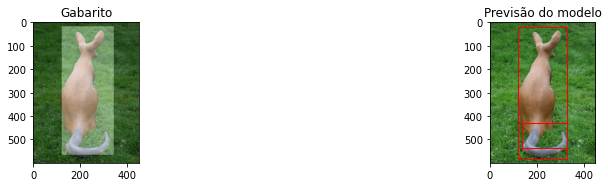

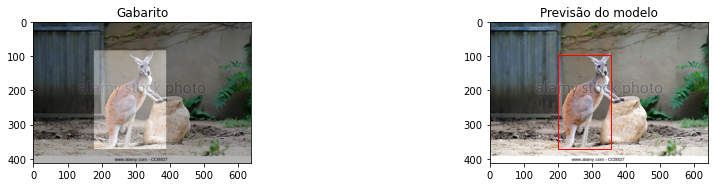

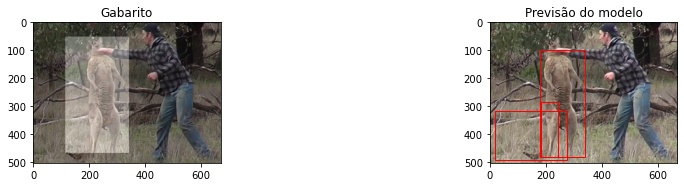

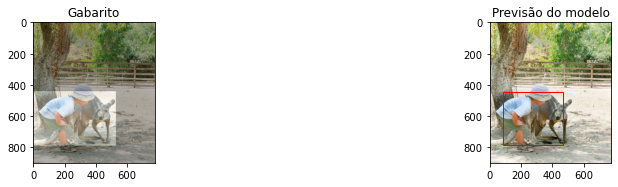

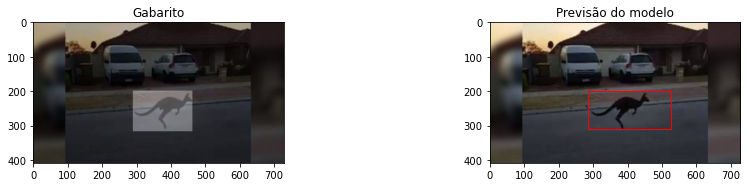

In [7]:
# Mostrando a detecção de cangurus

from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
from matplotlib.pyplot import figure
 
# Essa primeira parte do código é igual ao que já utilizamos
class DatasetCanguru(Dataset):
    def carrega_dataset(self, endereco_dataset, treino_selecionado=True):
        self.add_class("dataset", 1, "kangaroo")
        endereco_imagens = endereco_dataset + '/images/' 
        endereco_anotacoes = endereco_dataset + '/annots/'
        for nome_imagem in listdir(endereco_imagens): 
            imagem_id = nome_imagem[:-4] 
            if imagem_id in ['00090']:
                continue 
            if treino_selecionado and int(imagem_id) >= 150: 
                continue
            if not treino_selecionado and int(imagem_id) < 150: 
                continue
            diretorio_completo_imagem = endereco_imagens + nome_imagem 
            diretorio_completo_anotacao = endereco_anotacoes + imagem_id + '.xml' 
            self.add_image('dataset', image_id=imagem_id, path=diretorio_completo_imagem, annotation=diretorio_completo_anotacao) 
 
    def extrair_caixas(self, endereco_arquivo):
        arquivo = ElementTree.parse(endereco_arquivo) 
        raiz = arquivo.getroot() 
        caixas = []
        for caixa in raiz.findall('.//bndbox'):
            xmin = int(caixa.find('xmin').text)
            ymin = int(caixa.find('ymin').text)
            xmax = int(caixa.find('xmax').text)
            ymax = int(caixa.find('ymax').text)
            coordenadas = [xmin, ymin, xmax, ymax]
            caixas.append(coordenadas)
        largura = int(raiz.find('.//size/width').text)
        altura = int(raiz.find('.//size/height').text)
        return caixas, largura, altura
 
    def load_mask(self, imagem_id): 
        informacoes_imagem = self.image_info[imagem_id] 
        diretorio_anotacao = informacoes_imagem['annotation'] 
        caixas, l, a = self.extrair_caixas(diretorio_anotacao) 
        mascaras = zeros([a, l, len(caixas)], dtype='uint8') 
        classes_ids = []
        for i in range(len(caixas)): 
            caixa = caixas[i] 
            x_inicio, x_final = caixa[1], caixa[3] 
            y_inicio, y_final = caixa[0], caixa[2] 
            mascaras[x_inicio:x_final, y_inicio:y_final, i] = 1 
            classes_ids.append(self.class_names.index('kangaroo'))
        return mascaras, asarray(classes_ids, dtype='int32') 

# Criando uma classe para as configurações das previsões:
class ConfiguracoesPrevisoes(Config): 
    NAME = "configuracoes_previsoes"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# Criando função que mostra n imagens de teste, cada uma com sua máscara real e com a caixa prevista pelo modelo:
def plotando_atual_vs_prevista(dataset, modelo, cfg, n_imagens=5):
    for i in range(n_imagens): # varrendo as primeiras 2 imagens do dataset de teste
        imagem = dataset.load_image(i) # carrega cada imagem
        mascara, _ = dataset.load_mask(i) # carrega cada máscara
        imagem_centrada = mold_image(imagem, cfg) # aplicando centering
        amostra = expand_dims(imagem_centrada, 0) # criando a dimensão extra do batch_size
        dados = modelo.detect(amostra, verbose=0)[0] # fazendo a previsão dessa imagem
        figura = plt.figure(figsize=(15,15)) # tamanho da figura total (terá que comportar 4 imagens nesse caso)
        
        # Criando primeiro os subplots para mostrar as imagens de teste com suas máscaras reais:
        figura.add_subplot(n_imagens, 2, i*2+1) # quebra as linhas da figura em 2 partes e as colunas em 2 partes. Para cada imagem i, plota ela nos quadrantes da coluna esquerda (quadrantes ímpares)
        plt.imshow(imagem) # mostra a imagem
        plt.title('Gabarito') 
        # plotando as máscaras reais:
        for j in range(mascara.shape[2]):
            plt.imshow(mascara[:, :, j], cmap='gray', alpha=0.3) # desenha a máscara
            
        # Criando os subplots para mostrar as imagens de teste com suas caixas previstas pelo modelo:
        figura.add_subplot(n_imagens, 2, i*2+2) # quebra as linhas da figura em 2 partes e as colunas em 2 partes. Para cada imagem i, plota ela nos quadrantes da coluna direita (quadrantes pares)
        plt.imshow(imagem) # mostra a imagem 
        plt.title('Previsão do modelo')
        eixos = plt.gca() # gca significa "get current axis". Ele seleciona os eixos da figura atual.
        # plotando as caixas previstas:
        for caixa in dados['rois']: # coleta as informações da caixa prevista
            y1, x1, y2, x2 = caixa # coloca cada coordenada da caixa em uma variável
            largura, altura = x2 - x1, y2 - y1 # calcula a espessura e a altura da caixa
            retangulo = Rectangle((x1, y1), largura, altura, fill=False, color='red') # cria um retângulo (caixa)
            eixos.add_patch(retangulo) # adiciona o retângulo criado na figura
    # Resumindo: para cada imagem de teste, mostramos a imagem com sua máscara na esquerda e a imagem com sua caixa
    # prevista pelo modelo na direita.            
    plt.show()

# Criando o dataset de treino:
dataset_treino = DatasetCanguru() 
dataset_treino.carrega_dataset('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo', treino_selecionado=True) 
dataset_treino.prepare() 
print('Tamanho Treino: %d' % len(dataset_treino.image_ids))
 
# Criando o dataset de teste:
dataset_teste = DatasetCanguru()
dataset_teste.carrega_dataset('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo', treino_selecionado=False)
dataset_teste.prepare()
print('Tamanho Teste: %d' % len(dataset_teste.image_ids))

cfg = ConfiguracoesPrevisoes()

modelo = MaskRCNN(mode='inference', model_dir='C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/modelo_testando', config=cfg)

# Escolhendo qual modelo treinado utilizar para fazer a detecção de cangurus:
modelo.load_weights('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/treino/configuracoes_cangurus20220728T1102/mask_rcnn_configuracoes_cangurus_0005.h5', by_name=True)

# Mostrando as previsões no dataset de teste:
plotando_atual_vs_prevista(dataset_teste, modelo, cfg)

Re-starting from epoch 5


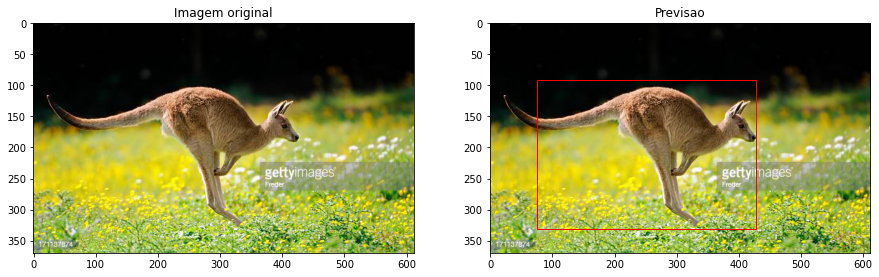

In [8]:
# Mostrando a aplicação funcionando com uma imagem nova aleatória
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
from matplotlib.pyplot import figure
from skimage.io import imread
 

class DatasetCanguru(Dataset):
    def carrega_dataset(self, endereco_dataset, treino_selecionado=True):
        self.add_class("dataset", 1, "kangaroo")
        endereco_imagens = endereco_dataset + '/images/' 
        endereco_anotacoes = endereco_dataset + '/annots/'
        for nome_imagem in listdir(endereco_imagens): 
            imagem_id = nome_imagem[:-4] 
            if imagem_id in ['00090']:
                continue 
            if treino_selecionado and int(imagem_id) >= 150: 
                continue
            if not treino_selecionado and int(imagem_id) < 150: 
                continue
            diretorio_completo_imagem = endereco_imagens + nome_imagem 
            diretorio_completo_anotacao = endereco_anotacoes + imagem_id + '.xml' 
            self.add_image('dataset', image_id=imagem_id, path=diretorio_completo_imagem, annotation=diretorio_completo_anotacao) 
 
    def extrair_caixas(self, endereco_arquivo):
        arquivo = ElementTree.parse(endereco_arquivo) 
        raiz = arquivo.getroot() 
        caixas = []
        for caixa in raiz.findall('.//bndbox'):
            xmin = int(caixa.find('xmin').text)
            ymin = int(caixa.find('ymin').text)
            xmax = int(caixa.find('xmax').text)
            ymax = int(caixa.find('ymax').text)
            coordenadas = [xmin, ymin, xmax, ymax]
            caixas.append(coordenadas)
        largura = int(raiz.find('.//size/width').text)
        altura = int(raiz.find('.//size/height').text)
        return caixas, largura, altura
 
    def load_mask(self, imagem_id): 
        informacoes_imagem = self.image_info[imagem_id] 
        diretorio_anotacao = informacoes_imagem['annotation'] 
        caixas, l, a = self.extrair_caixas(diretorio_anotacao) 
        mascaras = zeros([a, l, len(caixas)], dtype='uint8') 
        classes_ids = []
        for i in range(len(caixas)): 
            caixa = caixas[i] 
            x_inicio, x_final = caixa[1], caixa[3] 
            y_inicio, y_final = caixa[0], caixa[2] 
            mascaras[x_inicio:x_final, y_inicio:y_final, i] = 1 
            classes_ids.append(self.class_names.index('kangaroo'))
        return mascaras, asarray(classes_ids, dtype='int32') 

# Criando uma classe para as configurações das previsões:
class ConfiguracoesPrevisoes(Config): 
    NAME = "configuracoes_previsoes"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# Criando função que mostra n imagens de teste, cada uma com sua máscara real e com a caixa prevista pelo modelo:
def plotando_atual_vs_prevista(imagem, modelo, cfg):
    imagem_centrada = mold_image(imagem, cfg) # aplicando centering
    amostra = expand_dims(imagem_centrada, 0) # criando a dimensão extra do batch_size
    dados = modelo.detect(amostra, verbose=0)[0] # fazendo a previsão dessa imagem
    figura = plt.figure(figsize=(15,15)) # tamanho da figura total (irá comportar 2 imagens nesse caso)
    # Criando o subplot para mostrar a imagem atual sem previsão:
    figura.add_subplot(1, 2, 1) # quebra a figura em duas partes nas colunas. Irá colocar a imagem carregada na esquerda.
    plt.imshow(imagem) # mostra a imagem
    plt.title('Imagem original') 
    figura.add_subplot(1, 2, 2) # quebra a figura em duas partes nas colunas. Irá colocar a detecção do modelo na direita.
    plt.imshow(imagem) # mostra a imagem
    plt.title('Previsao')
    eixos = plt.gca()
    # plotando as caixas previstas:
    for caixa in dados['rois']:
        y1, x1, y2, x2 = caixa
        largura, altura = x2 - x1, y2 - y1
        retangulo = Rectangle((x1, y1), largura, altura, fill=False, color='red')
        eixos.add_patch(retangulo) # adiciona o retângulo previsto pelo modelo na figura
    plt.show()

# Carregando a imagem:
imagem_canguru = imread('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/modelo_testando/CanguruTeste.jpg')

cfg = ConfiguracoesPrevisoes()

modelo = MaskRCNN(mode='inference', model_dir='C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/modelo_testando', config=cfg)
modelo.load_weights('C:/Users/Falcone/Documents/0_MachineLearning/2022.07.25_Environm_MaskRCNN/2022.07.25_kangaroo/treino/configuracoes_cangurus20220728T1102/mask_rcnn_configuracoes_cangurus_0005.h5', by_name=True)

# Mostrando as previsões da imagem:
plotando_atual_vs_prevista(imagem_canguru, modelo, cfg)